# Benchmark of PYSCAL_GLASSVIEWER 

Pyscal_Glassviewer is a FORK of Pyscal, which is modified and improved for Metal Glass data post-processing tasks by Zihao Bai, Jilin University.
This Benchmark uses a POSCAR file from MD of Al melting process. In order to test the partial PDF module and SRO module, we label the atoms into Al1 and Al2. The properties is as following:

Box parameter:

    55.996 0.0 0.0
    0.0 56.923 0.0
    0.0 0.0 56.369
    
Atom Numbers:

    Al1 Al2
    10000 976 


## Initialization, Split Trajectory and Read Files

In [1]:
import sys
#sys1.path.append("../src")
import pyscal as pc
import pyscal.traj_process as ptp
import matplotlib.pyplot as plt
import numpy as np
import cChargeAnalysis 
import ChargeAnalysis
import calCD
import seaborn as sns
%matplotlib qt


In [3]:
files=ptp.split_trajectory('XDATCAR',format='poscar',makedir=True) #split the poscar from XDATCAR

In [2]:
step=1999
vol=[]
for i in files:
    
    format="poscar"
    sys1 = pc.System()
    sys1.read_inputfile(i, format=format)#format{'lammps-dump', 'poscar', 'ase', 'mdtraj'}
    sys1.get_rho_vol()
    vol.append(sys1.vol)
    print(i,sys1.vol,step)
    step=step+2000

NameError: name 'files' is not defined

Here we do not use the splitted trajectory above. Instead we choose a POSCAR which satisfy the condition described in the summary.

In [3]:
#file=files[40]
format="poscar"
sys1 = pc.System()
sys1.read_inputfile('XDATCAR.snap.50.dat', format=format)#format{'lammps-dump', 'poscar', 'ase', 'mdtraj'}
#sys1.read_inputfile('poscar', format=format)#format{'lammps-dump', 'poscar', 'ase', 'mdtraj'}

## Calculate the Charge Density

In [4]:
bohr=0.529177208607388

In [5]:
cChargcal=cChargeAnalysis.ChargeAnalysis()
cChargcal.debug=True
cChargcal.ChargeAnalysisInit('atlas.den50',np.sum(sys1.box,axis=0)/bohr,sys1.natoms)


In [6]:
modes=[2]
#modes=[3]# 0 for voronoisum 1 for cutoffsum 2 for pdf 3 for boo
modevoronoisum=0
modecutoffsum=1
modepdf=2
modeboo=3
allmodenum=4
threadnum=14
CDresults=[[] for i in range(allmodenum)]
cChargcal.threadnum=14
for mode in modes:
    if mode==3:
        boocut=3.645*1.5/bohr
        histlow=0
        histbin=1000
        boolist=[6]
        atomscut = sys1.atoms
        den=[0 for i in range(len(atomscut))]
        for atom in atomscut:
            den[atom.loc]=cChargcal.calculate_q_sumYdotCharge(boolist,np.array(atom.pos)/bohr,boocut,histlow,histbin)
        CDresults[mode]=den
                
    if mode==2:
        pdfcut=3.645*1.5/bohr
        histlow=0
        histbin=1000
        atomscut = sys1.atoms
        den=[0 for i in range(len(atomscut))]
        for atom in atomscut:
            den[atom.loc]=cChargcal.CD_pdf(np.array(atom.pos)/bohr,pdfcut,histlow,histbin)
            #print(den[atom.loc])
        CDresults[mode]=den
    if mode==1:
        CDSumCut=3.645/2/bohr
        atomscut = sys1.atoms
        den=[0 for i in range(len(atomscut))]
        for atom in atomscut:
            den[atom.loc]=cChargcal.SumMethod_cut(np.array(atom.pos)/bohr,CDSumCut)
            #print(den[atom.loc])
        CDresults[mode]=den
    if mode==0:
        sys1.find_neighbors(method="voronoi")#method can be selected among "cutoff voronoi number", details can 
        atomsvoro = sys1.atoms
        den=[0 for i in range(len(atomsvoro))]

        for atom in atomsvoro:
            v3s=[]
            st = 1
            for vno in atom.face_vertices:
                vphase = atom.vertex_numbers[st:st+vno]
                ipos = atom.vertex_positions[vphase[0]]
                jpos = atom.vertex_positions[vphase[int((len(vphase)-1)/2)]]
                kpos = atom.vertex_positions[vphase[len(vphase)-1]]
                v3s.append([ipos,jpos,kpos])
                st += (vno+1)
            
            den[atom.loc]=cChargcal.SumMethod_voro(np.array(v3s)/bohr,np.array(atom.vertex_positions)/bohr)
            #print(den[atom.loc])
        CDresults[mode]=den


In [8]:
# CDresults[mode][atom][real/img/Charge][l][m][hist_r]

ls=[6]
qlrlistdotcharge=[]
mode=3
ireal=0
iimg=1
iCharge=2
chargelist=[]

for atom in range(1):
    charge=np.average(np.average(CDresults[mode][atom][iCharge],axis=0),axis=0)
    chargelist.append(charge)
    qlrlistdotcharge.append([])
    for lth,l in enumerate(ls):
        qlrlistdotcharge[atom].append(np.zeros(len(charge)))
        
        for mth,m in enumerate(range(-l,l+1)):
            
            qlmr_real=np.array(CDresults[mode][atom][ireal][lth][mth])
            qlmr_img=np.array(CDresults[mode][atom][iimg][lth][mth])
            qlrlistdotcharge[atom][lth]+= qlmr_real*qlmr_real+qlmr_img*qlmr_img
        qlrlistdotcharge[atom][lth]*=4*np.pi/(2*l+1)
        qlrlistdotcharge[atom][lth]=qlrlistdotcharge[atom][lth]**(1/2)
qlr_r=np.linspace(0,boocut*bohr,len(charge),endpoint=False)

average_qlrdotcharge=np.average(qlrlistdotcharge,axis=0)[0]
averagecharge=np.average(chargelist,axis=0)
average_qlr=average_qlrdotcharge/averagecharge


plt.figure()
plt.plot(qlr_r,average_qlrdotcharge)
plt.show()
plt.figure()
plt.plot(qlr_r,averagecharge)
plt.show()

plt.figure()
plt.plot(qlr_r,average_qlr)
plt.show()



IndexError: list index out of range

## CD Debug Tools

In [9]:
gridtest=np.array(cChargcal.gridtest)

In [25]:
cChargcal.nxyz

[300, 300, 288]

In [10]:
plt.figure()
plt.hist(gridtest.reshape(cChargcal.nxyz[0]*cChargcal.nxyz[1]*cChargcal.nxyz[2]),range=[np.min(gridtest),np.max(gridtest)],bins=int(np.max(gridtest)-np.min(gridtest)))
plt.show()

In [21]:
x=[]
y=[]
z=[]
for i in range(cChargcal.nxyz[0]):
    for j in range(cChargcal.nxyz[1]):
        for k in range(cChargcal.nxyz[2]):
            if gridtest[i][j][k]==0:
                x.append(i)
                y.append(j)
                z.append(k)
                

In [12]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(x, y, z, c = 'm')
plt.show()

In [13]:
x

[]

In [15]:
rho=np.array(cChargcal.rho)

In [16]:
np.sum(rho)*cChargcal.dxvol

32928.000000000044

In [14]:
np.sum(den)

32927.999999999985

### for python version

In [ ]:
cChargcal=ChargeAnalysis.ChargeAnalysis()
cChargcal.debug=True
cChargcal.ChargeAnalysisInit('atlas.den50',np.sum(sys1.box,axis=0)/bohr,sys1.natoms)

sys1.find_neighbors(method="voronoi")#method can be selected among "cutoff voronoi number", details can 
atomsvoro = sys1.atoms
den=[0 for i in range(len(atomsvoro))]

for atom in atomsvoro:
    v3s=[]
    st = 1
    for vno in atom.face_vertices:
        vphase = atom.vertex_numbers[st:st+vno]
        ipos = atom.vertex_positions[vphase[0]]
        jpos = atom.vertex_positions[vphase[int((len(vphase)-1)/2)]]
        kpos = atom.vertex_positions[vphase[len(vphase)-1]]
        v3s.append([ipos,jpos,kpos])
        st += (vno+1)
    cChargcal.set_vertex(np.array(v3s)/bohr,np.array(atom.vertex_positions)/bohr)
    den[atom.loc]=cChargcal.SumMethod()
    print(den[atom.loc])



## Calculate Order Parameter and Show it

In [7]:
deviden13atoms=False

bins2d=100
cut2d=[3,4]
histq4w4range=[[0,0.25],[-0.2,0.2]]
histq4q8range=[[0,0.25],[0.15,0.5]]
histq4aq6range=[[0,0.25],[0,0.55]]
histaq4aq6range=[[0,0.2],[0,0.6]]
neighbordistrange=(10,18)
histq4w4=[]
histq4q8=[]
histq4aq6=[]
histaq4aq6=[]
neighbordist=[]
solidnum=0
precursornum=0
neighborthreshold2d=2
precursoraq6cut=0.25
showmode='all' #all precursor solid

import warnings
warnings.simplefilter('ignore', np.RankWarning)
pdfbintemp=int(200*(cut2d[1]-cut2d[0]))

pdf, r=sys1.calculate_pdf(histobins=pdfbintemp,histomin=cut2d[0],cut=cut2d[1],threadnum=1)
c1=np.polyfit(r,pdf,20)
yfit1=np.polyval(c1,r)
cut1=(np.argmin(yfit1))

min2=np.max([0,cut1-100])
max2=np.min([pdfbintemp,cut1+100])

c2=np.polyfit(r[min2:max2],pdf[min2:max2],20)
yfit2=np.polyval(c2,r)
cut2=(np.argmin(yfit2[min2:max2])+min2)
cutoffv=cut2d[0]+cut2*(cut2d[1]-cut2d[0])/pdfbintemp

sys1.find_neighbors(method='cutoff',cutoff=cutoffv)

if deviden13atoms:
    atom13list=set()
    for atomi,atom in enumerate(sys1.atoms):
        if len(atom.neighbors)==13:
            atom13list.add(atomi)

    atom13to12list=set()
    atom13to14list=set()
    if len(atom13list)>0:
        sys1.find_neighbors_bynumber_atomlist(threshold=neighborthreshold2d,nmax=14,atomlist=list(atom13list))

    atomstemp=sys1.atoms

    for atomi in atom13list:
        atom=atomstemp[atomi]
        delta= (atom.neighbor_distance[13-1]+atom.neighbor_distance[14-1])/2-cutoffv
        if delta>0:
            atom13to12list.add(atomi)
        elif delta<=0:
            atom13to14list.add(atomi)
    if len(atom13to12list)>0:
        sys1.find_neighbors_bynumber_atomlist(threshold=neighborthreshold2d,nmax=12,atomlist=list(atom13to12list))
    if len(atom13to14list)>0:
        sys1.find_neighbors_bynumber_atomlist(threshold=neighborthreshold2d,nmax=14,atomlist=list(atom13to14list))

sys1.calculate_q([4,6,8],averaged=False,clear_condition=True)
sys1.find_solids(bonds=7,threshold=0.7,cluster=False)
sys1.calculate_q([4,6,8],averaged=True,condition='solid',only_averaged=True)
sys1.calculate_w(4,averaged=False)

atomslist=set(sys1.atoms)
solidlist=set()
for atomi,atom in enumerate(atomslist):
    if atom.solid:
        solidlist.add(atom)

liquidlist=set()
for atomi,atom in enumerate(atomslist):
    if not atom.solid:
        liquidlist.add(atom)

aq6_cutlist=set()
for atomi,atom in enumerate(atomslist):
    if atom.get_q(6,True)>precursoraq6cut:
        aq6_cutlist.add(atom)

precursorlist=liquidlist.intersection(aq6_cutlist)

if showmode=='precursor':
    showlist=precursorlist
if showmode=='solid':
    showlist=solidlist
if showmode=='all':
    showlist=atomslist

q4=[]
q6=[]
q8=[]
aq4=[]
aq6=[]
w4=[]
for atom in showlist:
    q4.append(atom.get_q(4,False))
    q6.append(atom.get_q(6,False))
    q8.append(atom.get_q(8,False))
    aq4.append(atom.get_q(4,True))
    aq6.append(atom.get_q(6,True))
    w4.append(sys1.w[0][atom.loc])   
solidnum=len(solidlist)
precursornum=len(precursorlist)
histq4w4,X,Y=np.histogram2d(x=q4,y=w4,bins=bins2d,density=False,range=histq4w4range)
histq4q8,X,Y=np.histogram2d(x=q4,y=q8,bins=bins2d,density=False,range=histq4q8range)
histq4aq6,X,Y=np.histogram2d(x=q4,y=aq6,bins=bins2d,density=False,range=histq4aq6range)
histaq4aq6,X,Y=np.histogram2d(x=aq4,y=aq6,bins=bins2d,density=False,range=histaq4aq6range)
a=np.array([len(atom.neighbors) for atom in atomslist])
neighbordist,r=np.histogram(range=neighbordistrange,a=a,bins=(neighbordistrange[1]-neighbordistrange[0]))


In [ ]:
print('solidnum:',solidnum)
print('precursornum:',precursornum)
#plt.style.use(['science','no-latex'])
savefig=False
#basecolorbar=np.array([0.02,0.05,0.1,0.2,0.3,0.5,0.7,0.9,1])
#basecolorbar=np.array(np.linspace(0,1,11))
def colorbarfunc(array):
    array=np.array(array)
    return np.linspace(array[~np.isneginf(array)].min(),array[~np.isneginf(array)].max(),11)

with np.errstate(divide='ignore'):
    histq4q8log=np.log(histq4q8)
    histq4w4log=np.log(histq4w4)
    histq4aq6log=np.log(histq4aq6)
    histaq4aq6log=np.log(histaq4aq6)

    
heightbarq4q8=colorbarfunc(histq4q8log)
heightbarq4w4=colorbarfunc(histq4w4log)
heightbarq4aq6=colorbarfunc(histq4aq6log)
heightbaraq4aq6=colorbarfunc(histaq4aq6log)

histq4q8log[np.isneginf(histq4q8log)]=1e100
histq4w4log[np.isneginf(histq4w4log)]=1e100
histq4aq6log[np.isneginf(histq4aq6log)]=1e100
histaq4aq6log[np.isneginf(histaq4aq6log)]=1e100

#from IPython import embed
#embed()
hist,X,Y=np.histogram2d(x=[histq4q8range[0][0]],y=[histq4q8range[1][0]],bins=bins2d,density=True,range=histq4q8range)
x,y=np.meshgrid(X[0:len(X)-1],Y[0:len(Y)-1],indexing='ij')
#heightbar=colorbarfunc(histq4q8)
plt.figure(dpi=150)
sns.set()
plt.contourf(x,y,histq4q8log,heightbarq4q8,cmap='tab20b')
plt.colorbar()
plt.title('q4-q8 distribution')
plt.xlabel('q4')
plt.ylabel('q8')
if(savefig==True):
    plt.savefig('q4-q8'+plotextraname+'.png')
    plt.close()
else:
    plt.show()

hist,X,Y=np.histogram2d(x=[histq4w4range[0][0]],y=[histq4w4range[1][0]],bins=bins2d,density=True,range=histq4w4range)
x,y=np.meshgrid(X[0:len(X)-1],Y[0:len(Y)-1],indexing='ij')
#heightbar=colorbarfunc(histq4w4)
plt.figure(dpi=150)
sns.set()
#from IPython import embed
#embed()
plt.contourf(x,y,histq4w4log,heightbarq4w4,cmap='tab20b')
plt.colorbar()
plt.title('q4-w4 distribution')
plt.xlabel('q4')
plt.ylabel('w4')
if(savefig==True):
    plt.savefig('q4-w4'+plotextraname+'.png')
    plt.close()
else:
    plt.show()

hist,X,Y=np.histogram2d(x=[histq4aq6range[0][0]],y=[histq4aq6range[1][0]],bins=bins2d,density=True,range=histq4aq6range)
x,y=np.meshgrid(X[0:len(X)-1],Y[0:len(Y)-1],indexing='ij')
#heightbar=colorbarfunc(histq4aq6)
plt.figure(dpi=150)
sns.set()
plt.contourf(x,y,histq4aq6log,heightbarq4aq6,cmap='tab20b')
plt.colorbar()
plt.title('q4-aq6 distribution')
plt.xlabel('q4')
plt.ylabel('aq6')
if(savefig==True):
    plt.savefig('q4-aq6'+plotextraname+'.png')
    plt.close()
else:
    plt.show()

hist,X,Y=np.histogram2d(x=[histaq4aq6range[0][0]],y=[histaq4aq6range[1][0]],bins=bins2d,density=True,range=histaq4aq6range)
x,y=np.meshgrid(X[0:len(X)-1],Y[0:len(Y)-1],indexing='ij')
#heightbar=colorbarfunc(histaq4aq6)
plt.figure(dpi=150)
sns.set()
plt.contourf(x,y,histaq4aq6log,heightbaraq4aq6,cmap='tab20b')
plt.colorbar()
plt.title('aq4-aq6 distribution')
plt.xlabel('aq4')
plt.ylabel('aq6')
if(savefig==True):
    plt.savefig('aq4-aq6'+plotextraname+'.png')
    plt.close()
else:
    plt.show()

plt.figure(dpi=150)
plt.bar(x=range(neighbordistrange[0],neighbordistrange[1]),height=neighbordist)
plt.title('neighbor number distribution')
plt.xlabel('neighbor number')
plt.ylabel('count')
if(savefig==True):
    plt.savefig('neighbornumberdistribution'+plotextraname+'.png')
    plt.close()
else:
    plt.show()

            

## compare the ChargeDensity of atoms with different order

In [26]:
np.average([len(atom.neighbors) for atom in liquidlist])

12.478133398485218

In [27]:
np.average([len(atom.neighbors) for atom in precursorlist])

12.186617100371747

In [28]:
np.average([len(atom.neighbors) for atom in solidlist])

12.177777777777777

In [8]:
atomslist=set(sys1.atoms)
n11list=set()
n12list=set()
n13list=set()
n14list=set()
n15list=set()
for atom in atomslist:
    if len(atom.neighbors)==11:
        n11list.add(atom)
    if len(atom.neighbors)==12:
        n12list.add(atom)
    if len(atom.neighbors)==13:
        n13list.add(atom)
    if len(atom.neighbors)==14:
        n14list.add(atom)
    if len(atom.neighbors)==15:
        n15list.add(atom)

allCD=[[] for i in range(allmodenum)]
liquidCD=[[] for i in range(allmodenum)]
solidCD=[[] for i in range(allmodenum)]
precursorCD=[[] for i in range(allmodenum)]

n11CD=[[] for i in range(allmodenum)]
n12CD=[[] for i in range(allmodenum)]
n13CD=[[] for i in range(allmodenum)]
n14CD=[[] for i in range(allmodenum)]
n15CD=[[] for i in range(allmodenum)]

for a in modes:

    allCD[a]=[CDresults[a][atom.loc] for atom in atomslist]
    liquidCD[a]=[CDresults[a][atom.loc] for atom in liquidlist]
    solidCD[a]=[CDresults[a][atom.loc] for atom in solidlist]
    precursorCD[a]=[CDresults[a][atom.loc] for atom in precursorlist]

    n11CD[a]=[CDresults[a][atom.loc] for atom in n11list]
    n12CD[a]=[CDresults[a][atom.loc] for atom in n12list]
    n13CD[a]=[CDresults[a][atom.loc] for atom in n13list]
    n14CD[a]=[CDresults[a][atom.loc] for atom in n14list]
    n15CD[a]=[CDresults[a][atom.loc] for atom in n15list]



In [9]:
savefig=False
if not deviden13atoms:
    plotlist=[n11CD,n12CD,n13CD,n14CD,n15CD,liquidCD,precursorCD,solidCD,allCD]
    plotliststr=["n11CD","n12CD","n13CD","n14CD","n15CD",'liquidCD','precursorCD','solidCD',"all"]
    subfigrow=3
    subfigcol=4
    subfigsize=(16,12)
else:
    plotlist=[n11CD,n12CD,n14CD,n15CD,liquidCD,precursorCD,solidCD,allCD]
    plotliststr=["n11CD","n12CD","n14CD","n15CD",'liquidCD','precursorCD','solidCD',"all"]
    subfigrow=2
    subfigcol=4
    subfigsize=(16,8)

In [10]:

plotmax=histbin
plotmin=int(histbin/5)
plt.figure( dpi=150,figsize=subfigsize)
sns.set()
for i,a in enumerate( plotlist):
    plt.subplot(subfigrow,subfigcol,i+1)
    stri=plotliststr[i]
    savefig=False
    CDbin=50
    r=bohr*(np.linspace(histlow,pdfcut,histbin,endpoint=False)+(pdfcut-histlow)/histbin/2)
    atomnum=len(a[modepdf])
    temp=np.sum(a[modepdf],axis=0)/atomnum
   
    plt.plot(r[plotmin:plotmax],temp[plotmin:plotmax])
    plt.title(str(atomnum)+' Atom-'+stri)
    plt.xlabel('Distance/Å')
    plt.ylabel('Charge Density')
    plt.ylim(0.023,0.033)
plt.suptitle('ChargeDensity Ratial Distribution')
plt.tight_layout()
if(savefig==True):
    plt.savefig('CDRDF'+plotextraname+'.png')
    plt.close()
else:
    plt.show()


In [12]:
CDbin=50
plt.figure( dpi=150,figsize=subfigsize)
sns.set()
for i,a in enumerate( plotlist):
    plt.subplot(subfigrow,subfigcol,i+1)
    stri=plotliststr[i]
    plt.hist(a[modecutoffsum],bins=CDbin)
    plt.title('Atoms-'+stri)
    plt.xlabel('ChargeSum')
    plt.ylabel('count')
plt.suptitle('ChargeSummation in Cut '+'%5.3f'%CDSumCut)
plt.tight_layout()
if(savefig==True):
    plt.savefig('CDCutSum'+'%5.3f'%CDSumCut+plotextraname+'.png')
    plt.close()
else:
    plt.show()


# Other Tools

## PDF-Total

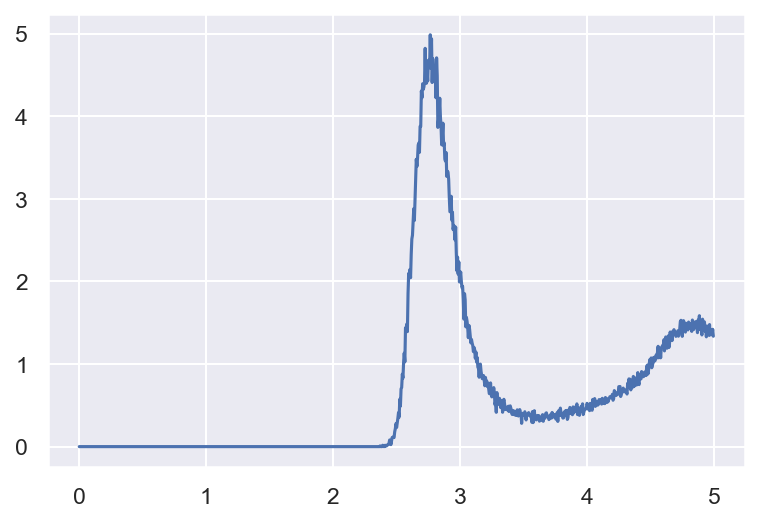

In [9]:

histnum=1000#直方图分割数量(密度)
pdf, r=sys1.calculate_pdf(histobins=histnum,histomin=0,cut=5,threadnum=20)
plt.figure(dpi=150)
plt.plot(r,pdf);
plt.show()

## PDF-Partial

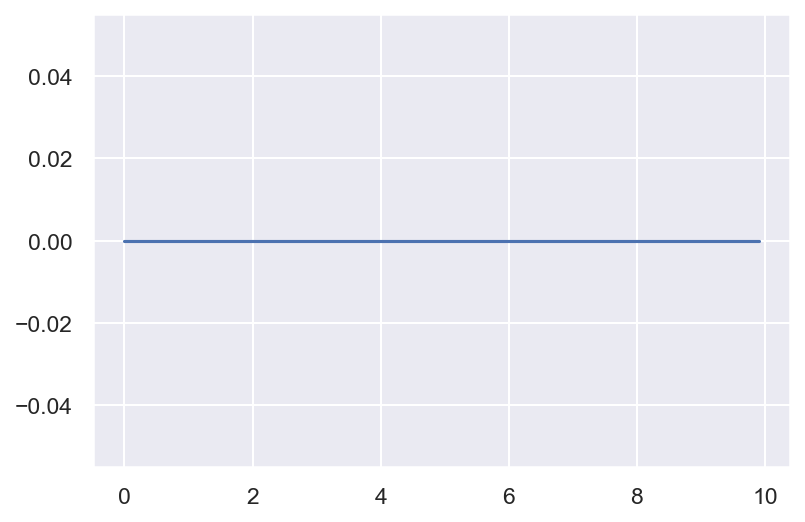

0.0
1.0


In [7]:
histnum=100#直方图分割数量(密度)
pdfp, r=sys1.calculate_pdf(histobins=histnum,histomin=0,cut=10,partial=True,centertype=1,secondtype=2,threadnum=10)
#sns.set()
plt.figure(dpi=150)
plt.plot(r,pdfp);
plt.show()
print(np.average( pdfp[-100:-1]))
print(1/sys1.natoms*sys1.ntotal)

## Bond Angle Distribution

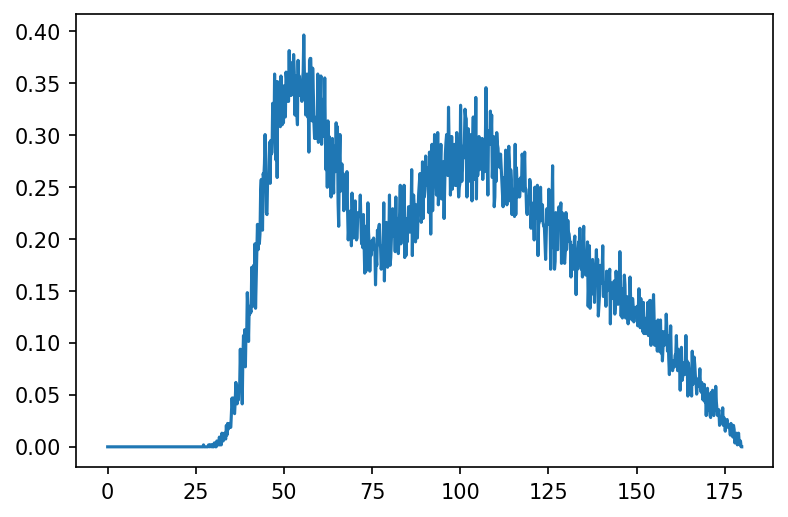

In [19]:
bad, r2=sys1.calculate_bad(histobins=1000,histomin=0,histomax=np.pi);
plt.figure(dpi=150)
plt.plot(r2*180/np.pi,bad);

## Structure Factor-FFT Method

In [ ]:
sf,q=sys1.calculate_sf(pdf, r,0);
plt.figure(dpi=150)
plt.plot(q[0:int(len(q)/20/histnum*2000)],sf[0:int(len(sf)/20/histnum*2000)]);


## Structure Factor-Integration Method

In [ ]:
sf,q=sys1.calculate_sf(pdf, r,10);
plt.figure(dpi=150)
plt.plot(q[0:int(len(q)/20/histnum*2000)],sf[0:int(len(sf)/20/histnum*2000)]);

## SRO-Cowley

In [ ]:
SRO_Cowley=sys1.calculate_pmsro(reference_type=1,compare_type=2)
print('The Cowley SRO is '+str(SRO_Cowley[0]))

## SRO-Cargill-Spaepen

In [ ]:
SRO_CS_unnorm=sys1.calculate_pmsro_CS(reference_type=1,compare_type=2,normalization=False)
SRO_CS_norm=sys1.calculate_pmsro_CS(reference_type=1,compare_type=2,normalization=True)
print('The Cowley SRO (unnormalized) is '+str(SRO_CS_unnorm))
print('The Cowley SRO (nnormalized)  is '+str(SRO_CS_norm))


## CNA

In [ ]:
CNA=sys1.calculate_cna()
print('CNA statistics of the system is '+str(CNA))
print('the structure number of atom0 is: '+str(sys1.atoms[0].structure))

## Voronoi Structure Identification

In [ ]:
sys1.calculate_vorovector()
print('the vorovector (n3, n4, n5, n6) for Atom 0 is '+str(sys1.atoms[0].vorovector))

## BOO

In [ ]:
sys1.calculate_q([2,4,5,6])
BOO=sys1.get_qvals([2,4,5,6])
print('the BOO number (q2, q4, q5, q6) for Atom 0 is '+str(BOO[0][0])+' '+str(BOO[0][1])+' '+str(BOO[0][2])+' '+str(BOO[0][3]))

In [8]:
sys1.calculate_vorovector()
print('the vorovector (n3, n4, n5, n6) for Atom 0 is '+str(sys1.atoms[0].vorovector))

the vorovector (n3, n4, n5, n6) for Atom 0 is [0, 12, 0, 0]


## Output the Atom Configuration and Atom Property

In [15]:
sys1.to_file('out',format='poscar')#We can directly output the atom configuration into poscar 
sys1.to_file('out'+file,format='lammps-dump',customkeys=['aq2','aq4','aq5','aq6'])
#aqn for average qn, qn for qn, other key name is the same with the attribute name, only lammps support custumkeys


c:\Users\baizh\anaconda3\lib\site-packages\pyscal-2.10.15-py3.9-win-amd64.egg\pyscal\formats\vasp.py:61: UserWarning: Using legacy poscar writer, to use ASE backend specify species
  warnings.warn("Using legacy poscar writer, to use ASE backend specify species")


## Visualization tool

This is a interactive tool which can only be used in Jupyter Notebook environment, and cannot be seen here.

In [7]:
sys1.show()

interactive(children=(FloatSlider(value=1.0, description='radius', max=30.0, min=1.0, step=1.0), Text(value='S…